In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

I had some difficulties uninstalling pytorch without cuda to replace it so I just created another virtual env and ran it in that. (I think this only needs to be done when you try to run it local)

After activating the venv you can install the pytorch with cuda with the following command.

`pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html`


In [133]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [35]:
# torch.zeros(1).cuda()

In [134]:
#I had a 
train_csv = pd.read_csv("./fashion-mnist_train.csv")
test_csv = pd.read_csv("./fashion-mnist_test.csv")

In [135]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [136]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

All the above has been done to load data in batches into the model. We use the DataLoader class from torch.utils.data. We also initialize the device to be used as the GPU instead of CPU.

The FashionDataset class has two methods: 
- get_item(index) -> image and label of item at index
- len() -> number of items in the dataset

In [137]:
# Mapping label number to a more meaningful label

def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

2


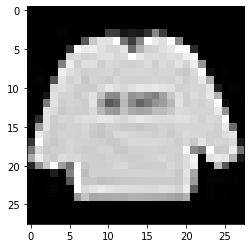

In [138]:
# displaying image using matplotlib imshow()
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [42]:
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_images[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[train_labels[i]])
# plt.show()


In [139]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, 

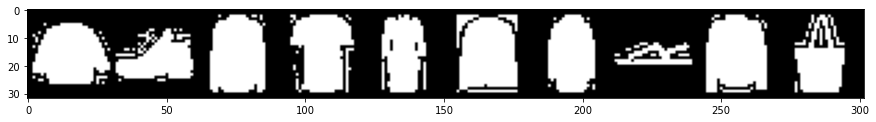

In [140]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

1. Make a model class (inherits nn.Module class)
2. Add Layers to model class

    a. Convolution layer with kernel size 3*3, padding = 1 (no padding) in 1st layer and padding = 0 in second layer. Stride of 1 in both layers.

    b. Batch normalization layer

    c. Activation function used: ReLU

    d. Max Pooling layer with kernel size of 2 * 2 and stride 2.

        i. flatten out output for dense layer

        ii. 3 fully connected layers with different in/out features

        iii. 1 dropout layer with p=0.25

Summary is as follows:

First conv layer -> Max Pooling layer -> Second conv layer -> second max pooling layer

28 * 28 * 3      --> 28 * 28 * 32      --> 14 * 14 * 32      --> 12 * 12 * 64              --> 6 * 6 * 64

Final fully connected layer has 10 output features for 10 types of clothes.

In [141]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [142]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [47]:
# # Training and Testing (OLD)
# num_epochs = 10 # num of epochs can also be increased > 100
# count = 0
# # Lists for visualization of loss and accuracy 
# loss_list = []
# iteration_list = []
# accuracy_list = []

# # Lists for knowing classwise accuracy
# predictions_list = []
# labels_list = []

# for epoch in range(num_epochs):
#     for images, labels in train_loader:
#         # Transfering images and labels to GPU if available
#         images, labels = images.to(device), labels.to(device)
    
#         train = Variable(images.view(100, 1, 28, 28)) # Apparently Variable is outdated so maybe we should change it
#         labels = Variable(labels)
        
#         # Forward pass 
#         outputs = model(train)
#         loss = error(outputs, labels)
        
#         # Initializing a gradient as 0 so there is no mixing of gradient among the batches
#         optimizer.zero_grad()
        
#         #Propagating the error backward
#         loss.backward()
        
#         # Optimizing the parameters
#         optimizer.step()
    
#         count += 1
    
#     # Testing the model
    
#         if not (count % 50):    # It's same as "if count % 50 == 0"
#             total = 0
#             correct = 0
        
#             for images, labels in test_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 labels_list.append(labels)
            
#                 test = Variable(images.view(100, 1, 28, 28))
            
#                 outputs = model(test)
            
#                 predictions = torch.max(outputs, 1)[1].to(device)
#                 predictions_list.append(predictions)
#                 correct += (predictions == labels).sum()
            
#                 total += len(labels)
            
#             accuracy = correct * 100 / total
#             loss_list.append(loss.data)
#             iteration_list.append(count)
#             accuracy_list.append(accuracy)
        
#         if not (count % 500):
#             print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Visualizing the results

In [143]:
train_accu = []
train_losses = []

def train(model, error, optimizer, loader, epoch):
  model.train()

  running_loss=0
  correct=0
  total=0
  
  for images, labels in loader:
    # Transfering images and labels to GPU if available
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass 
    outputs = model(images)
    loss = error(outputs, labels)
    
    # Initializing a gradient as 0 so there is no mixing of gradient among the batches
    optimizer.zero_grad()
    
    #Propagating the error backward
    loss.backward()
    
    # Optimizing the parameters
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(loader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  return train_loss, accu

In [144]:
eval_losses=[]
eval_accu=[]
 
def test(model, error, loader, epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = error(outputs, labels)

      running_loss += loss.item()

      _, predictions = outputs.max(1)
      total += labels.size(0)
      correct += predictions.eq(labels).sum().item()
   
  test_loss=running_loss/len(loader)
  accu=100.*correct/total
 
  eval_losses.append(test_loss)
  eval_accu.append(accu)
 
  return test_loss, accu

In [145]:
epochs=11
train_accu, eval_accu, train_losses, eval_losses = [], [], [], []
for epoch in range(1,epochs+1): 
  train_loss, train_accuracy = train(model, error, optimizer, train_loader, epoch)
  test_loss, test_accuracy = test(model, error, test_loader, epoch)
  print("Epoch: {}\nTrain: Loss: {}, Accuracy: {}%\nTest: Loss {}, Accuracy: {}%".format(epoch, train_loss, train_accuracy, test_loss, test_accuracy))
  

Epoch: 1
Train: Loss: 0.4436210860560338, Accuracy: 84.17166666666667%
Test: Loss 0.391604061126709, Accuracy: 84.8%
Epoch: 2
Train: Loss: 0.30136471038063367, Accuracy: 89.17833333333333%
Test: Loss 0.2904663306226333, Accuracy: 89.21666666666667%
Epoch: 3
Train: Loss: 0.26341772517810264, Accuracy: 90.67%
Test: Loss 0.23522375393658876, Accuracy: 91.38166666666666%
Epoch: 4
Train: Loss: 0.2387717725460728, Accuracy: 91.52666666666667%
Test: Loss 0.1971765160995225, Accuracy: 93.01666666666667%
Epoch: 5
Train: Loss: 0.22006316730131706, Accuracy: 92.10333333333334%
Test: Loss 0.18304740494117142, Accuracy: 93.46833333333333%
Epoch: 6
Train: Loss: 0.20518008564909299, Accuracy: 92.63833333333334%
Test: Loss 0.17327251942207417, Accuracy: 93.82833333333333%
Epoch: 7
Train: Loss: 0.19110197351003685, Accuracy: 93.15166666666667%
Test: Loss 0.16453583862632512, Accuracy: 94.165%
Epoch: 8
Train: Loss: 0.17873178826024136, Accuracy: 93.61833333333334%
Test: Loss 0.1558293948074182, Accuracy

In [147]:
import os

if not os.path.exists('./diagrams'):
    os.makedirs('./diagrams')

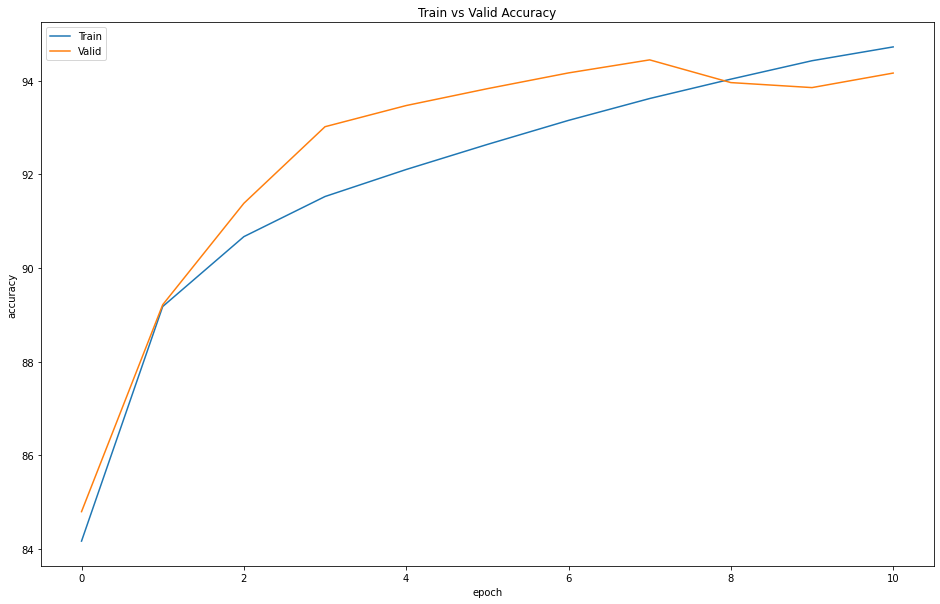

In [148]:
plt.figure(figsize=(16,10))

plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.savefig('./diagrams/cNN_Train_vs_Valid_Acc.png')

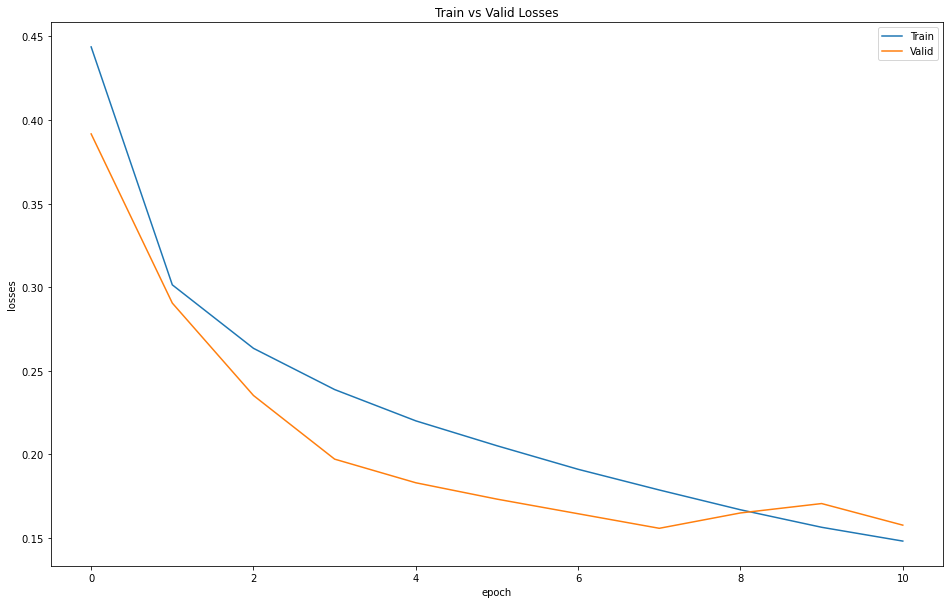

In [149]:
plt.figure(figsize=(16,10))

plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.savefig('./diagrams/cNN_Train_vs_Valid_loss.png')

From the graph we can see a downward trend of loss vs epoch. Perhaps a reason for the spikes in loss could be just due to the randomness of the batch sampling. An unlucky sampling could have led to the loss increasing compared to the previous iterations but overall the loss has a downward trend as iterations increase.

In [150]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

all_labels = torch.Tensor();
all_predicted = torch.Tensor();

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        c = (predicted == labels).squeeze()

        all_labels = torch.cat((all_labels, labels))
        all_predicted = torch.cat((all_predicted, predicted))
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 91.15%
Accuracy of Trouser: 99.97%
Accuracy of Pullover: 92.85%
Accuracy of Dress: 96.18%
Accuracy of Coat: 96.27%
Accuracy of Sandal: 99.73%
Accuracy of Shirt: 71.82%
Accuracy of Sneaker: 94.65%
Accuracy of Bag: 99.40%
Accuracy of Ankle Boot: 99.60%


In [151]:
from sklearn.metrics import confusion_matrix

confusion_matrix(all_labels, all_predicted)

array([[5469,    7,   76,  115,   19,    2,  304,    0,    3,    5],
       [   0, 5998,    0,    2,    0,    0,    0,    0,    0,    0],
       [  39,    8, 5571,   28,  307,    0,   45,    0,    2,    0],
       [  45,   71,   15, 5771,   71,    0,   22,    0,    4,    1],
       [   6,    8,  124,   68, 5776,    0,   18,    0,    0,    0],
       [   0,    1,    0,    0,    0, 5984,    0,    0,    1,   14],
       [ 350,    7,  350,  180,  802,    0, 4309,    0,    2,    0],
       [   0,    0,    0,    0,    0,   36,    0, 5679,    1,  284],
       [   0,    5,    2,    3,   16,    1,    8,    0, 5964,    1],
       [   0,    0,    0,    0,    0,    3,    0,   21,    0, 5976]],
      dtype=int64)

Classes with the lowest classification accuracy:
| Class       | Accuracy (%) | Classes that it is most confused with |
|-------------|--------------|---------------------------------------|
| Dress       | 98.93        | Coat, T-shirt/top                     |
| Coat        | 98.53        | Pullover, Dress                       |
| Pullover    | 97.27        | Coat, Shirt                           |
| T-shirt/top | 96.98        | Shirt, Dress, Pullover                |
| Shirt       | 95.95        | Coat, T-shirt/top, Pullover, Dress    |

In [146]:
# Create another cNN that is only trained on those classes with the lowest classification accuracies
# and the classes that they are confused with, i.e. T-shirt/top, Pullover, Dress, Coat, Shirt

lowest_accuracy_classes = [0, 2, 3, 4, 6]

train_csv_subset = train_csv[train_csv.label.isin(lowest_accuracy_classes)]
test_csv_subset = test_csv[test_csv.label.isin(lowest_accuracy_classes)]

train_subset = FashionDataset(train_csv_subset, transform=transforms.Compose([transforms.ToTensor()]))
test_subset = FashionDataset(test_csv_subset, transform=transforms.Compose([transforms.ToTensor()]))

train_subset_loader = DataLoader(train_subset, batch_size=100)
test_subset_loader = DataLoader(test_subset, batch_size=100)

In [115]:
model2 = FashionCNN()
model2.to(device)

error2 = nn.CrossEntropyLoss()

learning_rate2 = 0.001
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate2)
print(model2)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [125]:
epochs=3
train_accu, eval_accu, train_losses, eval_losses = [], [], [], []
for epoch in range(1,epochs+1): 
  train_loss, train_accuracy = train(model2, error2, optimizer2, train_subset_loader, epoch)
  test_loss, test_accuracy = test(model2, error2, test_subset_loader, epoch)
  print("Epoch: {}\nTrain: Loss: {}, Accuracy: {}%\nTest: Loss {}, Accuracy: {}%".format(epoch, train_loss, train_accuracy, test_loss, test_accuracy))
  

Epoch: 1
Train: Loss: 0.31268084205687047, Accuracy: 88.84666666666666%
Test: Loss 0.48842347085475923, Accuracy: 83.06%
Epoch: 2
Train: Loss: 0.30165887003143627, Accuracy: 89.17%
Test: Loss 0.4418901056051254, Accuracy: 85.18%
Epoch: 3
Train: Loss: 0.2837481978535652, Accuracy: 89.96666666666667%
Test: Loss 0.4321367684006691, Accuracy: 85.38%


In [126]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

all_labels = torch.Tensor();
all_predicted = torch.Tensor();

with torch.no_grad():
    for images, labels in test_subset_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = outputs.max(1)
        c = (predicted == labels).squeeze()

        all_labels = torch.cat((all_labels, labels))
        all_predicted = torch.cat((all_predicted, predicted))
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    if i in lowest_accuracy_classes:
        print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 80.30%
Accuracy of Pullover: 80.50%
Accuracy of Dress: 96.70%
Accuracy of Coat: 84.70%
Accuracy of Shirt: 84.70%


In [127]:
confusion_matrix(all_labels, all_predicted)

array([[803,   8,  23,   1, 165],
       [ 11, 805,  20,  56, 108],
       [ 11,   1, 967,   3,  18],
       [  1,  16,  69, 847,  67],
       [ 63,  20,  39,  31, 847]], dtype=int64)

In [184]:
confused_classes_to_repredict = [2, 4] # KIV as an experiment (swap out lowest_accuracy_classes with this as the prediction swap criteria*)

In [187]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

all_labels = torch.Tensor();
all_predicted = torch.Tensor();

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        # if the batch of predicted results includes a prediction of a low accuracy class
        for i in lowest_accuracy_classes:
            if i in predicted:
                # run the batch through the second cNN trained on low accuracy classes
                outputs2 = model2(images)
                _, predicted2 = outputs2.max(1)
                # swap out predictions for select* classes from the first model for predictions from the second model
                predicted_new = predicted
                index = 0
                for j in predicted:
                    if j in lowest_accuracy_classes: # *either use this or lowest_accuracy_classes
                        # swap the old prediction for the one from the second model
                        predicted_new[index] = predicted2[index]
                    index = index + 1
                predicted = predicted_new
                break
        # NEW END
        c = (predicted == labels).squeeze()

        all_labels = torch.cat((all_labels, labels))
        all_predicted = torch.cat((all_predicted, predicted))
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 84.67%
Accuracy of Trouser: 99.97%
Accuracy of Pullover: 85.37%
Accuracy of Dress: 97.63%
Accuracy of Coat: 87.43%
Accuracy of Sandal: 99.73%
Accuracy of Shirt: 91.95%
Accuracy of Sneaker: 94.65%
Accuracy of Bag: 99.40%
Accuracy of Ankle Boot: 99.60%


In [188]:
confusion_matrix(all_labels, all_predicted)

array([[5080,    7,   11,  103,    5,    2,  784,    0,    3,    5],
       [   0, 5998,    0,    2,    0,    0,    0,    0,    0,    0],
       [  50,    8, 5122,  101,  199,    0,  518,    0,    2,    0],
       [  14,   71,    2, 5858,    8,    0,   42,    0,    4,    1],
       [   3,    8,  103,  373, 5246,    0,  267,    0,    0,    0],
       [   0,    1,    0,    0,    0, 5984,    0,    0,    1,   14],
       [ 182,    7,   72,  132,   88,    0, 5517,    0,    2,    0],
       [   0,    0,    0,    0,    0,   36,    0, 5679,    1,  284],
       [   1,    5,    0,    4,    6,    1,   18,    0, 5964,    1],
       [   0,    0,    0,    0,    0,    3,    0,   21,    0, 5976]],
      dtype=int64)

In [59]:
# https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [60]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i].children():
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [61]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([32, 1, 3, 3])
CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 3, 3])


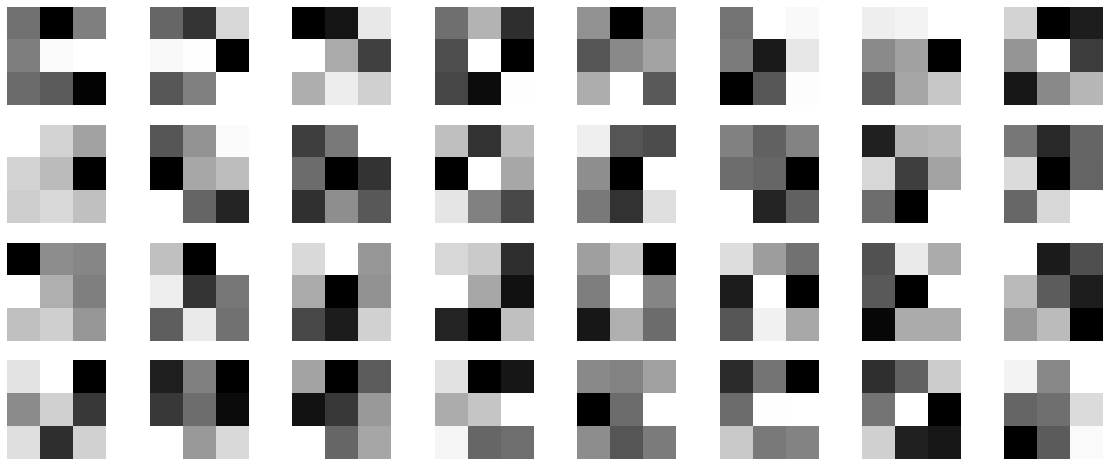

In [62]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0].cpu()):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./diagrams/filter1.png')
plt.show()

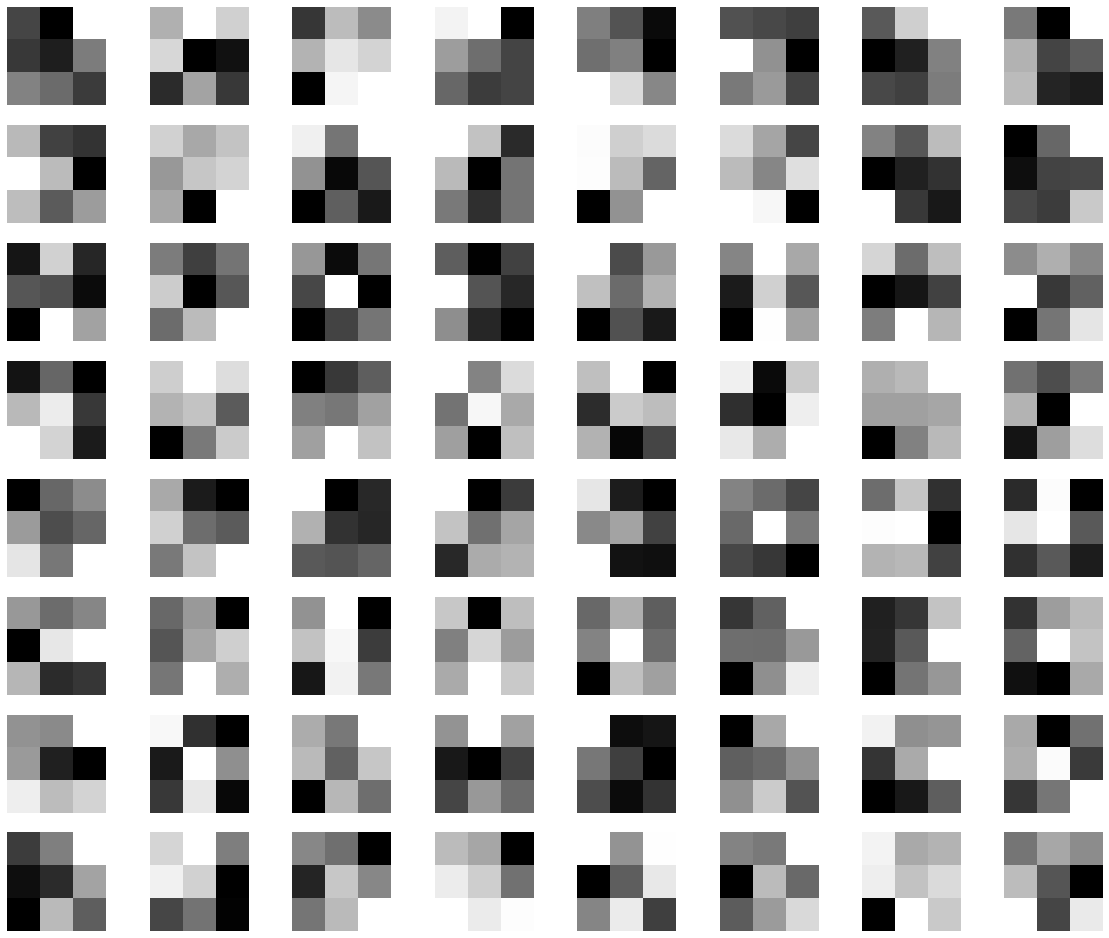

In [63]:
# visualize the second conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1].cpu()):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./diagrams/filter2.png')
plt.show()

In [64]:
print(model_weights[0].cpu())

Parameter containing:
tensor([[[[ 0.0242, -0.2114,  0.0501],
          [ 0.0488,  0.3043,  0.3151],
          [ 0.0098, -0.0236, -0.2044]]],


        [[[-0.1099, -0.2319,  0.1707],
          [ 0.2554,  0.2679, -0.3667],
          [-0.1486, -0.0448,  0.2728]]],


        [[[-0.3543, -0.3108,  0.1409],
          [ 0.1908,  0.0095, -0.2171],
          [ 0.0162,  0.1517,  0.0891]]],


        [[[-0.0011,  0.1405, -0.1363],
          [-0.0711,  0.2966, -0.2323],
          [-0.0870, -0.2073,  0.2932]]],


        [[[ 0.0290, -0.3168,  0.0384],
          [-0.1145,  0.0096,  0.0726],
          [ 0.0964,  0.2912, -0.1034]]],


        [[[-0.1296,  0.1841,  0.1698],
          [-0.1131, -0.3315,  0.1273],
          [-0.3889, -0.1922,  0.1788]]],


        [[[ 0.1402,  0.1530,  0.1761],
          [-0.0630, -0.0173, -0.3450],
          [-0.1563, -0.0081,  0.0604]]],


        [[[ 0.2065, -0.3341, -0.2587],
          [ 0.0501,  0.3216, -0.1794],
          [-0.2751,  0.0173,  0.1328]]],


        [[

In [65]:
plt.imsave('./diagrams/pullover.png', image.squeeze(), cmap="gray")

In [88]:
import cv2 as cv

# read and visualize an image
img = cv.imread(f"./diagrams/pullover.png")
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

ModuleNotFoundError: No module named 'cv2'

In [ ]:
# pass the image through all the layers
img = img.to(device)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

NameError: name 'img' is not defined

In [ ]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./diagrams/layer_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([32, 28, 28])
Saving layer 0 feature maps...
torch.Size([64, 26, 26])
Saving layer 1 feature maps...
